# Copyright

<PRE>
Jelen iPython notebook a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott "Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült.
A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning
Jelen notebook Nicolas P. Rougier munkája alapján készült, melyet BSD licensz véd: http://www.labri.fr/perso/nrougier/downloads/mlp.py

A notebook bármely részének újra felhasználása, publikálása csak a szerzők írásos beleegyezése esetén megegengedett.

2020 (c) Gyires-Tóth Bálint (toth.b kukac tmit pont bme pont hu), Császár Márk, Kalapos András
</PRE>

# XOR feladat neuron hálós megközelítése

Először a historikisan is nagy jelentőségű XOR problémát fogjuk megoldani "pure" Python-ban.

A XOR probléma a gépi tanulás szempontjából azért érdekes, mert míg az AND és az OR logikai függvények architektúrális szempontból megoldhatóak egyetlen neuron segítségével, addig a XOR-ra ez nem teljesül. Az AND és az OR esetében létezik a függvény által felveheto kimeneti értékek között egy olyan hipersík (szeparálósík), amely segítségével egyértelmű a szeparáció.

A XOR probléma további tárgyalásához tekintsük az alábbi igazságtáblát:


  A     | B   | A XOR B
  :----:| :----:|:--------:
  0     | 0   |    0
  1     | 0   |    1
  0     | 1   |    1
  1     | 1   |    0

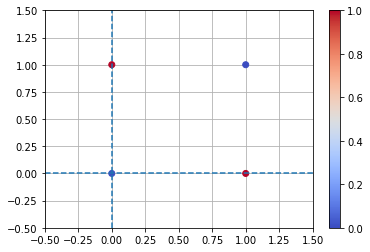

In [70]:
# A notebook alapú megjelenítés aktiválása
# (részletek: https://ipython.readthedocs.io/en/stable/interactive/plotting.html)
%matplotlib inline
import matplotlib.pyplot as plt # Pyplot grafikus megjelenítocsomag importálása
plt.rc('axes', axisbelow=True)  # Csinosítás: Rács, tengelyek, a grafikonok mögött

# A és B -> x és y bemeneti kombinációi és kimeneti értékek xor
xs   = [0, 1, 0, 1]
ys   = [0, 0, 1, 1]
xor  = [0, 1, 1, 0]
and_ = [0, 0, 0, 1]
or_  = [0, 1, 1, 1]

# Pontok ábrázolása. Piros -> 1 (Igaz), Kék-> 0(Hamis)
plt.scatter(xs, ys, c=xor, cmap='coolwarm')
# Megj.: megnézhetjünk 'c=and'_ és 'c=or_'-ral is a plottolást

# Csinosítás
# Színskála hozzáadása
plt.colorbar()

# A jobb ábrázálhatóság miatt, szélesebb tartományokat jelenítünk meg
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)

# Négyzetrács megjelenítése
plt.grid(True)

# Az x és y tengely megjelenítése
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed');

Mint ahogy a fenti ábrán is látszódik, nem tudjuk egyetlen szeparáló síkkal (2 dimenzióban egyenessel) külön választani az igaz és a hamis értékeket.

Mivel egyetlen síkkal nem tudjuk szétválasztani a kimeneteket ezért a neurális hálózat be- és kimeneti rétege közé szükségszerű, hogy további, un. rejtett réteg(ek)et illesszünk be.

## Neuron háló felépítése
Mielőtt a konkrét programkóddal ismerkednénk meg, tekintsük át egy mesterséges neurális hálózat általános architektúráját, felépítését. Ahhoz, hogy neurális hálózatunk felügyelt tanítás során rendeltetésszerűen működjön, szükségünk van:

 - Tanító adatokra (bemenet és felügyelt esetben kimenet),
 - Magára a neurális hálózatra, amely magában foglal:
   - bemeneti réteget, egy kimeneti réteget, illetve köztük elhelyezkedo rejtett réteg(ek)et,
   - rétegenként tetszőleges számú neuronokat,
   - a rétegeket összekötő, különböző súlyokkal rendelkező éleket,
   - a neuronokon elvégzett lineáris (súlyozott összegzés), illetve nem lineáris függvényeket (pl. sigmoid, tanh, ReLU, stb.).
 - Tanítási fázist:
   - a bemenő adatokat "végigküldjük" a hálózaton (forward propagation),
   - a bemenő adatok alapján kiszámoljuk a hálózat által "jósolt" eredményt,
   - a jósolt eredmény és a tanító adatokban szereplő elvárt eredmény közötti kapcsolat kiszámítása (költségfüggvény),
   - a kapott hibaérték visszaterjesztése (backpropagation) a hálózaton, a láncszabály és a parciális deriválás módszerével (gradiensek kiszámítása)
   - a rétegek közötti súlyok frissítését a gradiensek segítségével.
   
Első lépésként importáljuk a már jól ismert Numpy csomagot, amire np-ként fogunk hivatkozni, illetve a további szükséges csomagokat:

In [71]:
import numpy as np

### Aktivációs függvény
A "forward" lépésben a hálózatot alkotó neuronokkal két műveletet hajtunk végre: (1) Egy súlyozott lineáris összegzést, (2) illetve egy nemlineáris aktiválási függvényt. A lineáris függvény nem csinál mást, minthogy összegzi az adott neuronhoz beérkező értékeket a hozzá vezető súly értékével megszorozva. Ezután a kapott eredményen alkalmazzuk a nemlineáris aktivációs függvényt. Ez általában annyit csinál, hogy amennyiben az argumentuma (a korábbi szummázás)meghalad egy bizonyos küszöbértéket, akkor a neuron továbbítja a következő rétegre az adatokat. Itt a sigmoid-ot használjuk erre a célra, amit előbb definiálunk majd megnézzük, hogy hogyan néz ki:

$$
\mathrm{S}(x) = \frac{1}{1+e^{-x}}
$$

In [72]:
def activation(x):
    return np.abs(x)

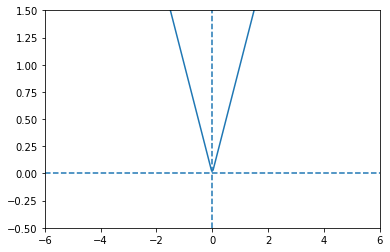

In [73]:
segedX = np.linspace(-6,6,200)
y = activation(segedX)
plt.plot(segedX, y)

# A jobb ábrázálhatóság miatt, szélesebb tartományokat jelenítünk meg
plt.xlim(-6, 6)
plt.ylim(-0.5, 1.5)
# Az x és y tengely megjelenítése
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed');

Következőnek definiáljuk az aktivációs függvény deriváltját. A tanítási fázis során, a hiba végigterjesztésekor (backpropagation) az aktivációs függvényt, azaz annak a deriváltját használjuk. Definiáljuk majd nézzük meg ezt is, hogy hogyan néz ki sigmoid esetén:

$$
\frac{d\mathrm{S}(x)}{dx} = \frac{e^{-x}}{(1+e^{-x})^2}
$$

In [74]:
def dactivation(x):    
    return np.where(x>0, 1, -1)

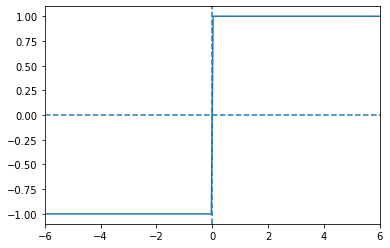

In [75]:
plt.plot(segedX, dactivation(segedX))
plt.xlim(-6, 6)
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed');

### Neuronhálót megvalósító osztály
Most jön a java! Definiáljuk az MLP osztályt négy függvénnyel: inicializálás, súlyok resetelése, forward lépés, backward lépés.

In [76]:
# MLP osztály létrehozása.
class MLP:

    def __init__(self, *args):
        """
        A hálózat inicializálása az argumentumként megadott méretek alapján.
        Példa példányosításra: network = MLP(2,10,1)
        """
        # random seed megadása
        np.random.seed(123)
        # A hálózat formája (rétegek száma), amely megegyezik a paraméterek számával
        self.shape = args
        n = len(args)
        # Rétegek létrehozása
        self.layers = []
        # Bemeneti réteg létrehozása (+1 egység a BIAS-nak)
        self.layers.append(np.ones(self.shape[0]+1))
        # Rejtett réteg(ek) és a kimeneti réteg létrehozása
        for i in range(1,n):
            self.layers.append(np.ones(self.shape[i]))
        # Súlymátrix létrehozása
        self.weights = []
        for i in range(n-1):
            self.weights.append(np.zeros((self.layers[i].size,
                                         self.layers[i+1].size)))
        # dw fogja tartalmazni a súlyok utolsó módosításait (később pl. a momentum módszer számára)
        self.dw = [0,]*len(self.weights)
        # Tároljunk el egy referenciát a standardizálást végző scaler objektumra, hiszen az adatokat később is ezzel kell elő-feldolgozzuk
        self.scaler = None
        # Súlyok újrainicializálása
        self.reset()

    def reset(self):
        """
        Súlyok újrainicializálása [-1, 1) intervallum fölött vett egyenletes eloszlás mintavételezésével
        """
        for i in range(len(self.weights)):
            # véletlen számok [0,1) tartományban
            Z = np.random.random((self.layers[i].size,self.layers[i+1].size))
            # átskálázzuk a súlyokat [-1,1) tartományba
            self.weights[i][...] = (2*Z-1)*1

    def propagate_forward(self, data):
        """
        A bemenő adatok végigküldése a hálózaton, kimeneti rétegig (forward propagation)
        """
        # Bemeneti réteg beállítása (tanító adatok)
        self.layers[0][0:-1] = data
        # Az adatok végigküldése a bemeneti rétegtől az utolsó előtti rétegig (az utolsó ugyanis a kimeneti réteg).
        # A szigmoid aktivációs függvény használatával, mátrixszorzások alkalmazásával.
        # Az előadáson a "layers" változót jelöltük "a"-val.
        for i in range(1,len(self.shape)):
            s_i = np.dot(self.layers[i-1], self.weights[i-1])
            self.layers[i][...] = activation(s_i)
        # Visszatérés a hálózat által becsült eredménnyel
        return self.layers[-1]

    def propagate_backward(self, target, lrate=0.1):
        """
        Hibavisszaterjesztés (backpropagation) definiálása.
        Args:
            target: címkék, a kimenetek elvárt értékei
            lrate:
                A a learning rate (tanulási ráta) paraméter befolyásolja, hogy a hálózat súlyait milyen
                mértékben módosítsuk a gradiens függvényében. Ha ez az érték túl magas, akkor a háló
                "oszcillálhat" egy lokális vagy globális minimum körül. Ha túl kicsi értéket választunk,
                akkor pedig jelentősen több időbe telik mire elérjük a legjobb megoldást vagy leakad egy
                lokális minimumban és sose éri el azt. Defaults to 0.1.

        Returns: az aktuális kimenetek és elvárt értékek alapján számított (négyzetes) hiba
        """
        deltas = []
        # Hiba: 1/2 (y-y_kalap)**2
        # Hiba deriváltjának kiszámítása a kimeneti rétegen (dC/dy_kalap)
        derror = -(target-self.layers[-1]) # y-y_kalap
        # error*dactivation(s(3))
        s_last = np.dot(self.layers[-2],self.weights[-1])
        delta_last = derror * dactivation(s_last)
        deltas.append(delta_last)
        # Gradiens kiszámítása a rejtett réteg(ek)ben
        for i in range(len(self.shape)-2,0,-1):
            s_i = np.dot(self.layers[i-1],self.weights[i-1])
            # pl. utolsó rejtett réteg: delta(3)*(W(2).T)*dactivation(s(2)) (lásd előadás)
            delta_i = np.dot(deltas[0],self.weights[i].T)*dactivation(s_i)
            # a háló eleje felé "lépkedünk, mindig a deltas tömb elejére szúrjuk be az aktuálisan kiszámítottat"
            deltas.insert(0,delta_i)
        # Súlyok módosítása
        for i in range(len(self.weights)):
            layer = np.atleast_2d(self.layers[i])
            delta = np.atleast_2d(deltas[i])
            # pl. utolsó rétegben: delta(3)*a(2) (lásd előadás)
            dw = -lrate*np.dot(layer.T,delta)
            # súlyok módosítása
            self.weights[i] += dw

            # a súlymódosítás eltárolása
            self.dw[i] = dw

        # Visszatérés a hibával
        error = (target-self.layers[-1])**2
        return error.sum()

In [77]:
from sklearn import preprocessing
def learn(network, X, Y, valid_split, test_split, epochs=20, lrate=0.1):

    # train-validation-test minták különválasztása
    nb_samples = len(Y)
    valid_start_idx = int(nb_samples*(1-valid_split-test_split))
    test_start_idx = int(nb_samples*(1-test_split))
    X_train = X[0:valid_start_idx]
    Y_train = Y[0:valid_start_idx]
    X_valid = X[valid_start_idx:test_start_idx]
    Y_valid = Y[valid_start_idx:test_start_idx]
    X_test  = X[test_start_idx:]
    Y_test  = Y[test_start_idx:]

    # standardizálás
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_valid = scaler.transform(X_valid)
    X_test  = scaler.transform(X_test)
    network.scaler = scaler

    # ugyanolyan sorrendben keverjük be a bemeneteket és kimeneteket, a három külön adatbázisra
    randperm = np.random.permutation(len(X_train))
    X_train, Y_train = X_train[randperm], Y_train[randperm]

    # Tanítási fázis, epoch-szor megyünk át 1-1 véltelenszerűen kiválasztott mintán.
    for i in range(epochs):
        # Jelen megoldás azt a módszert használja, hogy a megadott
        # tanító adatokon végigmegyünk és minden elemet először végigküldünk
        # a hálózaton, majd terjeszti vissza a kapott eltérést az
        # elvárt eredménytől. Ezt hívjuk SGD-ek (stochastic gradient descent).
        train_err = 0
        for k in range(X_train.shape[0]):
            network.propagate_forward( X_train[k] )
            train_err += network.propagate_backward( Y_train[k], lrate )
        train_err /= X_train.shape[0]

        # validációs fázis
        valid_err = 0
        o_valid = np.zeros(X_valid.shape[0])
        for k in range(X_valid.shape[0]):
            o_valid[k] = network.propagate_forward(X_valid[k])
            valid_err += (o_valid[k]-Y_valid[k])**2
        valid_err /= X_valid.shape[0]

        print("%d epoch, train_err: %.4f, valid_err: %.4f" % (i, train_err, valid_err))

    # Tesztelési fázis
    print("\n--- TESZTELÉS ---\n")
    test_err = 0
    o_test = np.zeros(X_test.shape[0])
    for k in range(X_test.shape[0]):
        o_test[k] = network.propagate_forward(X_test[k])
        test_err += (o_test[k]-Y_test[k])**2
        print(k, X_test[k], '%.2f' % o_test[k], ' (elvart eredmeny: %.2f)' % Y_test[k])
    test_err /= X_test.shape[0]

    plt.scatter(X_test[:,0], X_test[:,1], c=np.round(o_test[:]), cmap=plt.cm.coolwarm)
    plt.axhline(0)
    plt.axvline(0)

In [78]:
# Mesterséges neurális hálózat létrehozása, 2 bemenettel, 10 rejtett neuronnal és 1 kimenettel
network = MLP(2,10,1)

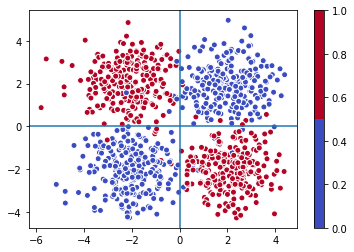

In [79]:
# Tanító, validációs és teszt adatok megadása a rendszernek (zajjal terhelt XOR adatok)
def get_2d_normal(nb_samples, loc=[0,0], scale=1.0, label=0, X=None, Y=None):
        """
        2D normál eloszlás mintavételezésével generál pontokat a megadott középpont körül és állít elő címkéket tartalmazó tömböt hozzájuk.
        Ha X, Y-ban megadunk egy "adathalmazt" mely tartalmaz már pontokat, a generált pontokat konkatenálja a meglévőkhöz.
        """
        X_new = np.random.normal(loc, scale, (nb_samples, 2))
        Y_new = np.repeat(label, nb_samples)
        if X is not None and Y is not None:
            X_new = np.concatenate([X, X_new], axis=0)
            Y_new = np.concatenate([Y, Y_new], axis=0)
        return X_new, Y_new


def get_dataset(nb_samples=1000):
    X, Y = get_2d_normal(nb_samples//4, [2, 2],   label=0)
    X, Y = get_2d_normal(nb_samples//4, [-2, -2], label=0, X=X, Y=Y)
    X, Y = get_2d_normal(nb_samples//4, [2, -2],  label=1, X=X, Y=Y)
    X, Y = get_2d_normal(nb_samples//4, [-2, 2],  label=1, X=X, Y=Y)

    randperm = np.random.permutation(len(X))
    X, Y = X[randperm], Y[randperm]
    return X, Y

# Alternatív kód az adatok generálására
# def get_dataset(nb_samples=1000):
#     X = np.zeros((nb_samples,2))
#     Y = np.zeros(nb_samples)
#     for i in range(0,nb_samples,4):
#         noise = np.random.normal(0,1,8)
#         X[i], Y[i] = (-2+noise[0],-2+noise[1]), 0
#         X[i+1], Y[i+1] = (2+noise[2],-2+noise[3]), 1
#         X[i+2], Y[i+2] = (-2+noise[4],2+noise[5]), 1
#         X[i+3], Y[i+3] = (2+noise[6],2+noise[7]), 0

X,Y = get_dataset()

plt.scatter(X[:,0],X[:,1],c=Y[:], cmap=plt.get_cmap('coolwarm',2), linewidth=1, edgecolors='w', vmin=0, vmax=1)
plt.axhline(0)
plt.axvline(0)
plt.colorbar();

0 epoch, train_err: 0.1231, valid_err: 0.0535
1 epoch, train_err: 0.0657, valid_err: 0.0509
2 epoch, train_err: 0.0614, valid_err: 0.0500
3 epoch, train_err: 0.0601, valid_err: 0.0499
4 epoch, train_err: 0.0595, valid_err: 0.0485
5 epoch, train_err: 0.0592, valid_err: 0.0490
6 epoch, train_err: 0.0591, valid_err: 0.0490
7 epoch, train_err: 0.0593, valid_err: 0.0494
8 epoch, train_err: 0.0590, valid_err: 0.0497
9 epoch, train_err: 0.0586, valid_err: 0.0493
10 epoch, train_err: 0.0586, valid_err: 0.0493
11 epoch, train_err: 0.0584, valid_err: 0.0491
12 epoch, train_err: 0.0584, valid_err: 0.0490
13 epoch, train_err: 0.0584, valid_err: 0.0485
14 epoch, train_err: 0.0586, valid_err: 0.0491
15 epoch, train_err: 0.0585, valid_err: 0.0484
16 epoch, train_err: 0.0586, valid_err: 0.0489
17 epoch, train_err: 0.0584, valid_err: 0.0480
18 epoch, train_err: 0.0590, valid_err: 0.0483
19 epoch, train_err: 0.0589, valid_err: 0.0486
20 epoch, train_err: 0.0587, valid_err: 0.0483
21 epoch, train_err: 0.

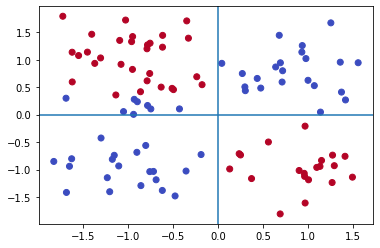

In [80]:
# Tanítás/Tesztelés indítása
network.reset()
valid_split = 0.2; test_split = 0.1
learn(network, X, Y, valid_split, test_split, epochs=100)

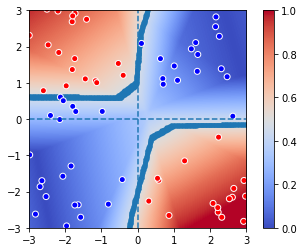

In [81]:
def decision_boundary_plot(network, X):
    """
    Háló kimenet illusztrálása a bemeneti sík "minden" (sok) pontjára
    Döntési határ közelítő megjelenítése
    Tesztontok megjelenítése és színezése a háló által becsült értékük szerint
    """
    # Generálunk a síkon egy sűrű rácsot, melynek minden pontjában kiértékeljük a háló kimenetét
    res = 300 # a egy-egy dimenzióban hány ponton értékeljük ki a kimenetet
    lims = 3  # A kirajzolás határának beállítása
    # lims = 10 értéket beállítva láthatjuk a háló általánosítóképességének korlátait
    x1 = x2 = np.linspace(-lims, lims, res)
    x1v, x2v = np.meshgrid(x1,x2)
    X_test2_grid = np.stack([x1v, x2v], axis=-1)
    X_test2 = np.reshape(X_test2_grid, (-1, 2))

    # Háló kimenet kiértékelése a rácspontokban
    Y_test2 = np.empty(X_test2.shape[0])
    X_test2_preprocessed = network.scaler.transform(X_test2)
    for i in range(X_test2.shape[0]):
        Y_test2[i] = network.propagate_forward(X_test2_preprocessed[i,:])
    Y_test2_grid = np.reshape(Y_test2, (res,-1))
    # Ábrázolás
    plt.imshow(Y_test2_grid, cmap=plt.cm.coolwarm, origin='lower', extent=[-lims-0.5, lims+.5, -lims-0.5, lims+0.5], vmax=1 ,vmin=-0)
    plt.colorbar()
    plt.axhline(0, linestyle='dashed')
    plt.axvline(0, linestyle='dashed')
    plt.xlim(-lims, lims)
    plt.ylim(-lims, lims)

    # Közelítő döntési határ megkeresése.
    # Megkeressük a rácson azokat a pontokat melyek értéke kb 0.5 és ezeket ábrázoljuk
    # A kapott döntési határ nem egy "szép" görbe, de közelítőleg megmutatja a döntési határt
    is_decision_boundary = np.isclose(Y_test2_grid, 0.5, atol=1e-2)
    # print(np.sum(is_decision_boundary))
    decision_boundary_coords = X_test2_grid[is_decision_boundary]
    # print(decision_boundary_coords.shape)
    plt.scatter(decision_boundary_coords[:,0], decision_boundary_coords[:,1], marker='.')

    # A adatbázis tesztpontjain (ismét) kiértékeljük a háló kimenetét és ezeket is kirajzoljuk
    nb_samples = X.shape[0]
    X_test = X[int(nb_samples*(1-test_split)):]
    X_test_preprocessed = network.scaler.transform(X_test)
    # Y_test  = Y[int(nb_samples*(1-test_split)):]
    O_test = np.zeros(X_test.shape[0])
    for k in range(X_test.shape[0]):
        O_test[k] = network.propagate_forward(X_test_preprocessed[k])
    plt.scatter(X_test[:,0], X_test[:,1], c=np.round(O_test[:]), cmap=plt.cm.bwr, linewidth=1, edgecolors='w')

decision_boundary_plot(network, X)